In [1]:
#declarations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string
from tqdm import tqdm
from scipy import stats
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import tensorflow as tf

dir_path_pkl = 'Processing_pickle_files\\'

# Filling Null values

In [9]:
#Filling all missing data with some default values

def fill_missing(df):
    
    df['item_description'].fillna('no description yet', inplace = True)
    df['brand_name'].fillna('missing', inplace = True)
    df['category_name'].fillna('missing/missing/missing', inplace = True)
    df['name'].fillna('no name', inplace=True)
    
    return df

# Text Pre-processing

In [10]:
def series_cleaning(series):
    
    series = series.apply(lambda x: x.lower())
    series = series.apply(lambda x: re.sub(r'[^\w\s]','',x))
    series = series.apply(lambda x: re.sub(' +',' ',x))
    
    return series

def text_cleaning(Input_Text):
    
    #if not pd.isnull(Input_Text)
    if len(Input_Text)>0:
        #decontractions
        Input_Text = Input_Text.lower()

        Input_Text = re.sub(r"won't", "will not", Input_Text)
        Input_Text = re.sub(r"can\'t", "can not", Input_Text)
        Input_Text = re.sub(r"n\'t", " not", Input_Text)
        Input_Text = re.sub(r"\'re", " are", Input_Text)
        Input_Text = re.sub(r"\'s", " is", Input_Text)
        Input_Text = re.sub(r"\'d", " would", Input_Text)
        Input_Text = re.sub(r"\'ll", " will", Input_Text)
        Input_Text = re.sub(r"\'t", " not", Input_Text)
        Input_Text = re.sub(r"\'ve", " have", Input_Text)
        Input_Text = re.sub(r"\'m", " am", Input_Text)
        Input_Text = re.sub(r'[^\w\s]','', Input_Text)
        Input_Text = re.sub(' +',' ', Input_Text)

    return Input_Text

def stopword_cleaning(Input_Text):
    
    Input_Text = text_cleaning(Input_Text)
    #stop word removal
    sw_list = stopwords.words('english')
    sw_list.remove('not')
    sw_list.remove('no')
    sw_list.remove('nor')
    Input_Text =  " ".join([i for i in Input_Text.split() if i not in sw_list])
    
    return Input_Text


#combining everything in 1 function
def text_preprocessing(series):
    
    series = series.apply(text_cleaning)
    series = series.apply(stopword_cleaning)
    series = series_cleaning(series)
    
    return series

# Filling Missing Brands

Attempting to identify the Brand based on Name and Category

In [11]:
def fill_missing_brands(df, train=False):
    
    if train==True:
        #get the list of existing brand names
        brands = list(df.brand_name[df.brand_name != 'missing'].unique())
        
        #we will create a dictionary to store the extracted brand name and the category they belong to
        brand_dict = {}

        for index, row in df[['brand_name', 'category_name']].iterrows():

            if row.brand_name != 'missing':

                if brand_dict.get(row.brand_name, -1) == -1:
                    brand_dict[row.brand_name] = {}
                    brand_dict[row.brand_name][str(row.category_name)] = 1
                else:
                    if brand_dict[row.brand_name].get(row.category_name, -1) == -1:
                        brand_dict[row.brand_name][str(row.category_name)] = 1
                    else: brand_dict[row.brand_name][str(row.category_name)] += 1
         
        f = open('brand_names_nested_dict', 'wb')
        pickle.dump(brand_dict, f)
        f.close()
            
    else:
        file_to_read = open("brand_names_nested_dict", "rb")
        brand_dict = pickle.load(file_to_read)

        count = 0 
        
        for index, row in df[['name','brand_name', 'category_name']].iterrows():

            if row.brand_name == 'missing':
                
                for brand in brand_dict.keys():
                    if brand in row['name']:
                        if brand_dict[brand].get(row['category_name'],-1)!=-1:
                            count+=1
                            df.loc[index, ['brand_name']] = brand

        print("missing Brands filled: ",count)
        
        return df

# Feature Engineering

In [12]:
def add_features(df):

    df['description_length'] = df['item_description'].apply(lambda x: len(x))
    print("Adding new features for length of Description")
    
    #merging name and Description
    df['combined'] = df['name']+ " " + df['item_description']
    print("Combining Name and Item Description")
    
    #splitting category feature
    df['Category'] = df.category_name.str.split('/', expand=True)[0]
    df['Sub_Category_1'] = df.category_name.str.split('/', expand=True)[1]
    df['Sub_Category_2'] = df.category_name.str.split('/', expand=True)[2]
    df = df.drop(['category_name','name', 'item_description'],axis=1)
    print("Splitting Categories")

    return df


# Stemming

In [13]:
def stemming(series):
    
    stemmer = PorterStemmer()

    for index, sentence in series.iteritems():
        new_sentence = ''   
        for word in sentence.split(" "):
            word = stemmer.stem(word)
            new_sentence += " "+ word
        series.loc[index] = new_sentence.strip()
        
    return series

# Pre-processing Pipeline

In [14]:
def preprocessing_pipeline(df, train=False):
    
    #filling Null values
    df = fill_missing(df)
    print("Null values filled")
    
    #text preprocessing
    df['name'] = text_preprocessing(df['name'])
    print("Text processing done for Name")
    
    df['brand_name'] = text_preprocessing(df['brand_name'])
    print("Text processing done for Brand_Name")
    
    df['item_description'] = text_preprocessing(df['item_description'])
    print("Text processing done for Description")
    
    print("Predicting brand based on Name and Category")
    if train==True:
        #this will save a dictioanry in pickle file
        fill_missing_brands(df, train=True)
    df = fill_missing_brands(df, train=False)
        
    #add features
    df = add_features(df)    
        
    #Performing Stemming on combined feature
    print("Performing Stemming on Combined feature")
    df['combined'] = stemming(df['combined'])
    
    print("Preprocessing Done", end='\n\n')
    print("-"*100, end='\n\n')
    
    return df

# Tokenizing and Padding

In [15]:
def tokenize_and_pad(corpus , maxlen, tokenizer=None):

    if tokenizer == None:
        tokenizer = Tokenizer(oov_token='#OOV#', num_words=None)  #num_words) #num_words=10000
        tokenizer.fit_on_texts(corpus)
    tokenized = tokenizer.texts_to_sequences(corpus)
    padded = pad_sequences(tokenized, maxlen=maxlen, padding='pre', truncating='post') #truncating='pre'
  
    return padded, len(tokenizer.word_counts), tokenizer

def standarization(corpus, scaler=None):
    
    if scaler == None:
        scaler = StandardScaler()
        scaler.fit(corpus)
    
    corpus = scaler.transform(corpus)
    
    return corpus, scaler

# Filtering Words based on TF-idf score

In [16]:
def filter_text(series, idf_dict):
 
    new_essay = []
 
    for text in tqdm(series):
  
        words = text.split(' ')
        for word in words:
            if idf_dict.get(word,-1)!=-1:
                words.remove(word)
        new_essay.append(' '.join(words))

    return new_essay

# Function 1 

In [53]:
def function_1(df):
    
    '''This function takes Raw input, performs all operation and Predicts the output'''
    
    #pre-processing 
    df = preprocessing_pipeline(df)
    
    #reading pickle files: all tokenizers,scalers and dictionary files required to process the input
    with open(dir_path_pkl + 'tokenizer_brandname.pkl', 'rb') as f:
        tokenizer_brandname = pickle.load(f)
    
    with open(dir_path_pkl + 'tokenizer_combined_col.pkl', 'rb') as f:
        tokenizer_combined_col = pickle.load(f)
    
    with open(dir_path_pkl + 'tokenizer_categories.pkl', 'rb') as f:
        tokenizer_categories = pickle.load(f)
    
    with open(dir_path_pkl + 'standard_scaler.pkl', 'rb') as f:
        standard_scaler = pickle.load(f)
    
    with open(dir_path_pkl + 'tfidf_filtered_words', 'rb') as f:
        tfidf_filtered_words = pickle.load(f)

        
    print("Filtering non-important words based on TF-idf value for Item Description field")    
    filtered_combined = filter_text(df['combined'], tfidf_filtered_words)
    
    #merging categories
    df['Categories'] = df['Category'] + " " + df['Sub_Category_1'] + " " + df['Sub_Category_2']

    print("Tokenizing input for brand_name")
    padded_brand, _, _ = tokenize_and_pad(df['brand_name'], maxlen=5, tokenizer=tokenizer_brandname)
    print("padded_brand: ", padded_brand.shape)
    
    print("Tokenizing input for Item Description and Name")
    padded_essay, _, _ = tokenize_and_pad(filtered_combined, maxlen=60, tokenizer=tokenizer_combined_col)
    print("padded_essay: ", padded_essay.shape)
    
    print("Tokenizing input for Categories")
    padded_category, _, _ = tokenize_and_pad(df['Categories'], maxlen=9, tokenizer=tokenizer_categories)
    print("padded_category: ", padded_category.shape)
    
    print("Tokenizing input for Numerical features")
    num_scaled, _ = standarization(df[['item_condition_id', 'shipping', 'description_length']], scaler = standard_scaler)
    print("num_scaled: ", num_scaled.shape, end='\n\n')

    df_validation = [padded_essay, padded_brand, padded_category, num_scaled]

    #reading model
    model = tf.keras.models.load_model(dir_path_pkl + "best_model_3b2.h5")
    
    #predicting values
    print("Predicting Values")
    predicted_prices = model.predict(df_validation)
    #converting into expected prices
    predicted_prices = np.exp(predicted_prices)
    predicted_prices = np.squeeze(predicted_prices, axis=1)
    
    #output = pd.DataFrame({'test_id': df['test_id'], 'price': predicted_prices})
    print(pd.DataFrame({'price':predicted_prices}))
    
    return pd.DataFrame({'price':predicted_prices})

# Function-2

In [ ]:
def function_2(df, targets):
    
    '''This function takes Raw input, performs all operation and Predicts the output'''
    
    #pre-processing 
    df = preprocessing_pipeline(df)
    
    #reading pickle files: all tokenizers,scalers and dictionary files required to process the input
    with open(dir_path_pkl + 'tokenizer_brandname.pkl', 'rb') as f:
        tokenizer_brandname = pickle.load(f)
    
    with open(dir_path_pkl + 'tokenizer_combined_col.pkl', 'rb') as f:
        tokenizer_combined_col = pickle.load(f)
    
    with open(dir_path_pkl + 'tokenizer_categories.pkl', 'rb') as f:
        tokenizer_categories = pickle.load(f)
    
    with open(dir_path_pkl + 'standard_scaler.pkl', 'rb') as f:
        standard_scaler = pickle.load(f)
    
    with open(dir_path_pkl + 'tfidf_filtered_words', 'rb') as f:
        tfidf_filtered_words = pickle.load(f)

        
    print("Filtering non-important words based on TF-idf value for Item Description field")    
    filtered_combined = filter_text(df['combined'], tfidf_filtered_words)
    
    #merging categories
    df['Categories'] = df['Category'] + " " + df['Sub_Category_1'] + " " + df['Sub_Category_2']

    print("Tokenizing input for brand_name")
    padded_brand, _, _ = tokenize_and_pad(df['brand_name'], maxlen=5, tokenizer=tokenizer_brandname)
    print("padded_brand: ", padded_brand.shape)
    
    print("Tokenizing input for Item Description and Name")
    padded_essay, _, _ = tokenize_and_pad(filtered_combined, maxlen=60, tokenizer=tokenizer_combined_col)
    print("padded_essay: ", padded_essay.shape)
    
    print("Tokenizing input for Categories")
    padded_category, _, _ = tokenize_and_pad(df['Categories'], maxlen=9, tokenizer=tokenizer_categories)
    print("padded_category: ", padded_category.shape)
    
    print("Tokenizing input for Numerical features")
    num_scaled, _ = standarization(df[['item_condition_id', 'shipping', 'description_length']], scaler = standard_scaler)
    print("num_scaled: ", num_scaled.shape, end='\n\n')

    df_validation = [padded_essay, padded_brand, padded_category, num_scaled]

    #reading model
    model = tf.keras.models.load_model(dir_path_pkl + "best_model_3b2.h5")
    
    #predicting values
    print("Predicting Values")
    predicted_prices = model.predict(df_validation)
    #converting into expected prices
    predicted_prices = np.exp(predicted_prices)
    predicted_prices = np.squeeze(predicted_prices, axis=1)
    
    rmse = np.sqrt(((predictions - targets) ** 2).mean())
    
    print("RMSE is: ", rmse)
    
    return rmse

# Reading Test dataset

In [18]:
Kaggle_testset = pd.read_csv("test_stg2.tsv", delimiter="\t")

# Calling function-1 to get Predictions 

In [19]:
predictions = function_1(Kaggle_testset)

Null values filled
Text processing done for Name
Text processing done for Brand_Name
Text processing done for Description
Predicting brand based on Name and Category
missing Brands filled:  926987
Adding new features for length of Description
Combining Name and Item Description
Splitting Categories
Performing Stemming on Combined feature
Preprocessing Done

----------------------------------------------------------------------------------------------------

Filtering non-important words based on TF-idf value for Item Description field


100%|████████████████████████████████████████████████████████████████████| 3460725/3460725 [00:17<00:00, 196432.06it/s]


Tokenizing input for brand_name
padded_brand:  (3460725, 5)
Tokenizing input for Item Description and Name
padded_essay:  (3460725, 60)
Tokenizing input for Categories
padded_category:  (3460725, 9)
Tokenizing input for Numerical features
num_scaled:  (3460725, 3)
Predicting Values
108148/108148 [==============================] - 1295s 12ms/step
             price
0         6.162757
1        12.536950
2        46.874966
3        15.570259
4        12.980899
...            ...
3460720   7.690559
3460721  44.567280
3460722  16.146822
3460723  21.332434
3460724  25.271450

[3460725 rows x 1 columns]


# Printing Values

In [22]:
predictions['test_id'] = Kaggle_testset['test_id']
predictions

,price,test_id
0,6.162757,0
1,12.536950,1
2,46.874966,2
3,15.570259,3
4,12.980899,4
...,...,...
3460720,7.690559,3460720
3460721,44.567280,3460721
3460722,16.146822,3460722
3460723,21.332434,3460723


# Scores

In [6]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "CV Error"]

table.add_row(['Benchmark','0.7438'])
table.add_row(['Lasso','0.6566'])
table.add_row(['Ridge','0.6566'])
table.add_row(['Decision Tree','0.6311'])
table.add_row(['Random Forest','0.5829'])
table.add_row(['LGBM','0.5110'])

table_DL = PrettyTable()
table_DL.field_names = ["Model", "CV Error"]

table_DL.add_row(['Features: Brand, Name & Description only. Embedding vector length 50','0.4456'])
table_DL.add_row(['All Features. Embedding vector length 50','0.4479'])
table_DL.add_row(['Filtering Name & Description with TF-IDF values','0.4358'])
table_DL.add_row(['All Features. Embedding vector length 100','0.4456'])


print("ML Models")
print(table)
print("DL Models")
print(table_DL)

ML Models
+---------------+----------+
|     Model     | CV Error |
+---------------+----------+
|   Benchmark   |  0.7438  |
|     Lasso     |  0.6566  |
|     Ridge     |  0.6566  |
| Decision Tree |  0.6311  |
| Random Forest |  0.5829  |
|      LGBM     |  0.5110  |
+---------------+----------+
DL Models
+----------------------------------------------------------------------+----------+
|                                Model                                 | CV Error |
+----------------------------------------------------------------------+----------+
| Features: Brand, Name & Description only. Embedding vector length 50 |  0.4456  |
|               All Features. Embedding vector length 50               |  0.4479  |
|           Filtering Name & Description with TF-IDF values            |  0.4358  |
|              All Features. Embedding vector length 100               |  0.4456  |
+----------------------------------------------------------------------+----------+


# Final score on Kaggle submission

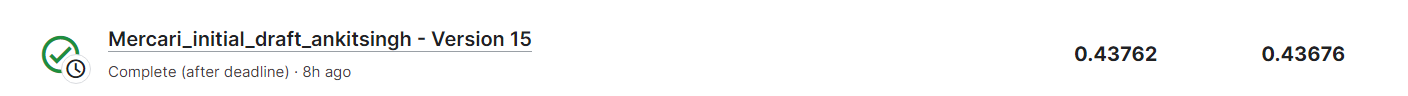